In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(5132, 300, 300, 3)
(5132, 1)
(3592, 300, 300, 3)
(770, 300, 300, 3)
(770, 300, 300, 3)


Using TensorFlow backend.


[0. 0. 0. ... 0. 0. 0.]
{0: 0.33595211372989153, 1: 85.52380952380952, 2: 85.52380952380952}
(3592, 3)
(770, 3)
(770, 3)


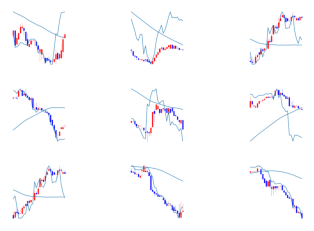





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 64)      1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 300, 300, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 128)     73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 150, 150, 128)     0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 128)       

KeyboardInterrupt: ignored

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display
%matplotlib inline


input_data_length = 30
model_num = 64

gdrive_path = '/content/gdrive/My Drive/Colab Notebooks/'

Made_X = np.load(gdrive_path + 'Made_X/Made_X %s_%s.npy' % (input_data_length,
                                              model_num)).astype(np.float32) / 255.
Made_Y = np.load(gdrive_path + 'Made_X/Made_Y %s_%s.npy' % (input_data_length,
                                              model_num)).astype(np.float32)

print(Made_X.shape)
print(Made_Y.shape)

row = Made_X.shape[1]
col = Made_X.shape[2]

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(Made_X, Made_Y, test_size=0.3,
                                                   shuffle=False)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5,
                                                   shuffle=False)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 

# Data Class Weight
from sklearn.utils import class_weight

print(Y_train[:, 0])
class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(Y_train[:, 0]),
                                                  Y_train[:, 0])
class_weights = dict(enumerate(class_weights))
print(class_weights)

num_classes = 3
Y_train = np_utils.to_categorical(Y_train, num_classes)
Y_val = np_utils.to_categorical(Y_val, num_classes)
Y_test = np_utils.to_categorical(Y_test, num_classes)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

datagen = ImageDataGenerator( 
#     rotation_range = 60,
#     zoom_range = 0.6,
#     shear_range = 0.6,
#     horizontal_flip = True,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    # fill_mode = 'nearest'
    )

testgen = ImageDataGenerator( 
    )
datagen.fit(X_train)
batch_size = 64

for X_batch, _ in datagen.flow(X_train, Y_train, batch_size=9):
    for i in range(0, 9): 
        plt.axis('off') 
        plt.subplot(330 + 1 + i) 
        plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
    plt.axis('off') 
    plt.show() 
    break
    
    
train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_val, Y_val, batch_size=batch_size) 
test_flow = testgen.flow(X_test, Y_test, batch_size=batch_size)


from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
# from keras.layers import LSTM, TimeDistributed, Input, Dense, Flatten, Dropout, BatchNormalization, Conv1D, LeakyReLU
# from keras.layers.convolutional import Conv2D
# from keras.layers.pooling import MaxPooling2D, MaxPooling1D
# from keras.layers.merge import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix

def FER_Model(input_shape=(row, col, 3)):
    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    net = layers.Conv2D(64, kernel_size=3, padding='same')(visible)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_1 = net

    net = layers.Conv2D(128, kernel_size=3, padding='same')(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_2 = net

    net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_3 = net

    net = layers.Conv2D(128, kernel_size=1, padding='same')(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.MaxPool2D(pool_size=2)(net)

    net = layers.Flatten()(net)
    net = layers.Dense(64)(net)
    net = layers.LeakyReLU()(net)
    net = layers.Dense(num_classes, activation='softmax')(net)

    # create model 
    model = Model(inputs =visible, outputs = net)
    # summary layers
    print(model.summary())
    
    return model

model = FER_Model()
# from keras.models import load_model

# model = load_model('model/rapid_ascending %s_%s_chart.hdf5' % (input_data_length, model_num))
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
       
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
filepath = gdrive_path + "model/rapid_ascending %s_%s_chart.hdf5" % (input_data_length, model_num)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
checkpoint2 = TensorBoard(log_dir='Tensorboard_graph',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
checkpoint3 = EarlyStopping(monitor='val_acc', patience=200)
callbacks_list = [checkpoint, checkpoint2, checkpoint3]

# keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

# we iterate 200 times over the entire training set
num_epochs = 1000
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    class_weight=class_weights,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size,
                    shuffle=False)



In [2]:
from keras.models import load_model

model = load_model(gdrive_path + 'model/rapid_ascending %s_%s_chart.hdf5' % (input_data_length, model_num))
# model = load_model('/content/gdrive/My Drive/Colab Notebooks/model/rapid_ascending %s.hdf5' % input_data_length)
loss = model.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

Test Loss 0.0040467931562430635
Test Acc: 1.0


In [3]:
Y_pred_ = model.predict(X_test, verbose=1)

770/770 [==============================] - 5s 7ms/step


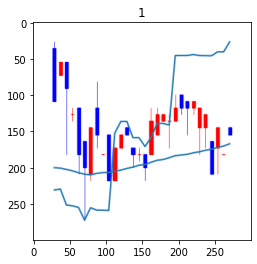

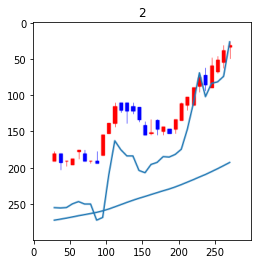

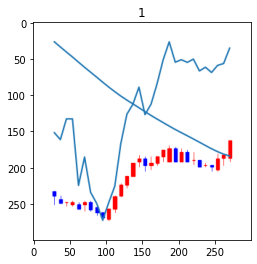

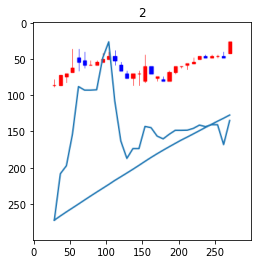

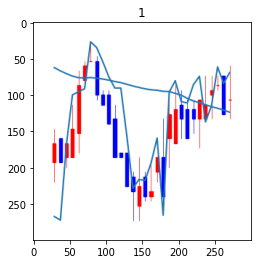

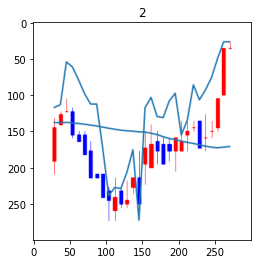

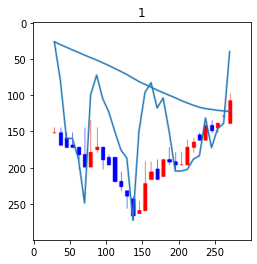

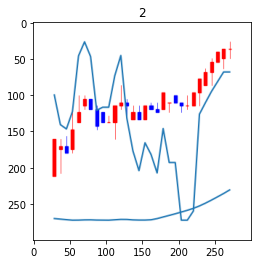

In [6]:
# loss = model.evaluate(X_val, Y_val) 
# print(X_val.shape)
# print(Y_val.shape)

# print("Val Loss " + str(loss[0]))
# print("Val Acc: " + str(loss[1]))

#     Prediction    #

# Y_pred = Y_pred_[:,[-1]]
# print(Y_pred.shape)
# print(Y_test.shape)
Y_pred = np.argmax(Y_pred_, axis=1)
t_te = np.argmax(Y_test, axis=1)



for i in range(len(X_test)):
  
  if Y_pred[i] in [1, 2]:
    plt.title(Y_pred[i])
    plt.imshow(X_test[i])
    plt.show()
# y_cnt = 0
# y_pred_cnt = 0
# for i in range(len(Y_pred)):
#   if t_te[i] == 1.:
#     y_cnt += 1
  
#   if Y_pred[i] == 1.:
#     y_pred_cnt += 1
# print(y_pred_cnt, y_cnt) 

#     Manual processing     #
# Y_pred_one = Y_pred_[:, [-1]]
# print(Y_pred_)
# max_value = np.max(Y_pred_, axis=0)
# print(max_value)

# limit_line = 0.9
# Y_pred_one = np.where(Y_pred_one > max_value * limit_line, 1, 0)

# # print(Y_pred_one)
# Y_pred_one = Y_pred_one.reshape(-1,)
# # print(Y_pred_1)
# # print(Y_pred.shape)
# # print(t_te.shape)

# # fail = 0
# # fail2 = 0
# # for i in range(len(Y_pred)):
# #   if Y_pred_1[i] != t_te[i]:
# #     fail += 1

# #   if Y_pred[i] != t_te[i]:
# #     fail2 += 1

# # print(1 - fail / len(Y_pred))
# # print(1 - fail2 / len(Y_pred))

# # print(np.sum(Y_pred), np.sum(t_te))
# # print('Y_pred / Y_test :', np.sum(Y_pred) / np.sum(t_te))
# %matplotlib inline
# plt.figure(figsize=(100,10))
# plt.subplot(211)
# plt.plot(Y_test, 'purple', label='test')

# plt.subplot(212)
# plt.plot(Y_pred_one, 'y', label='pred')
# plt.show()
# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/model/rapid_ascending %s.png' % input_data_length)
# plt.close()